# Relacion de Flujos

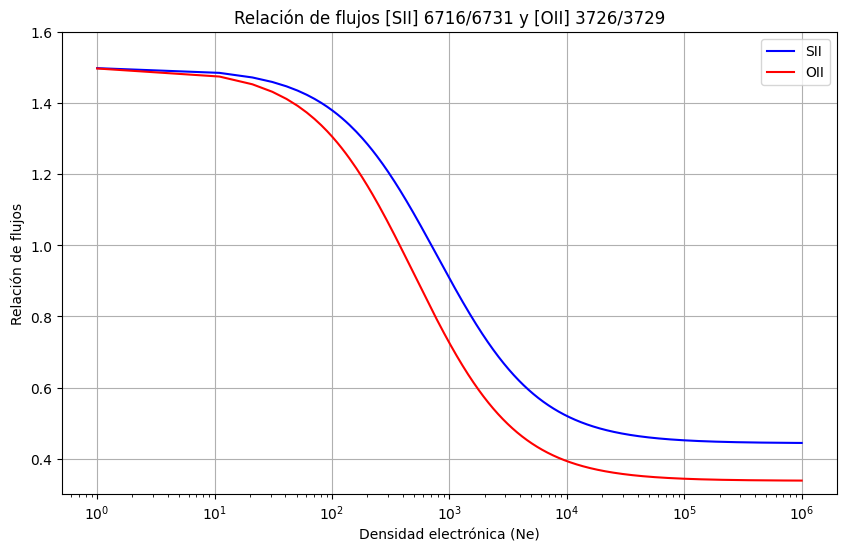

In [2]:
import numpy as np
import matplotlib.pyplot as plt

#funcion relacion de flujos
def f6716_over_f6731(Ne, C):
    A6716= 2.6e-4
    A6731 = 8.8e-4
    return (3/2)*(A6716/A6731)*((Ne*C+0.26*A6731)/(Ne*C+0.26*A6716))

def f3726_over_f3729(Ne, C):
    A3729 = 3.6e-5
    A3726 = 1.6e-4
    return (3/2)*(A3729/A3726)*((Ne*C+1.2*A3726)/(Ne*C+1.2*A3729))


#rango de Ne
Ne = np.linspace(1, 1000000, 100000)
Temperature = 10000  # Temperatura en Kelvin
C = 8.63e-6/np.sqrt(Temperature)  # Constante de densidad electrónica

ratio_SII = f6716_over_f6731(Ne, C)
ratio_OII = f3726_over_f3729(Ne, C)
# Graficar la relación de flujos
plt.figure(figsize=(10, 6))
plt.plot(Ne, ratio_SII, label='SII', color='blue')
plt.plot(Ne, ratio_OII, label='OII', color='red')
plt.title('Relación de flujos [SII] 6716/6731 y [OII] 3726/3729')
plt.xlabel('Densidad electrónica (Ne)')
plt.ylabel('Relación de flujos')
plt.xscale('log')
#plt.yscale('log')
plt.ylim(0.3, 1.6)
#plt.xlim()
plt.legend()
plt.grid()
plt.show()

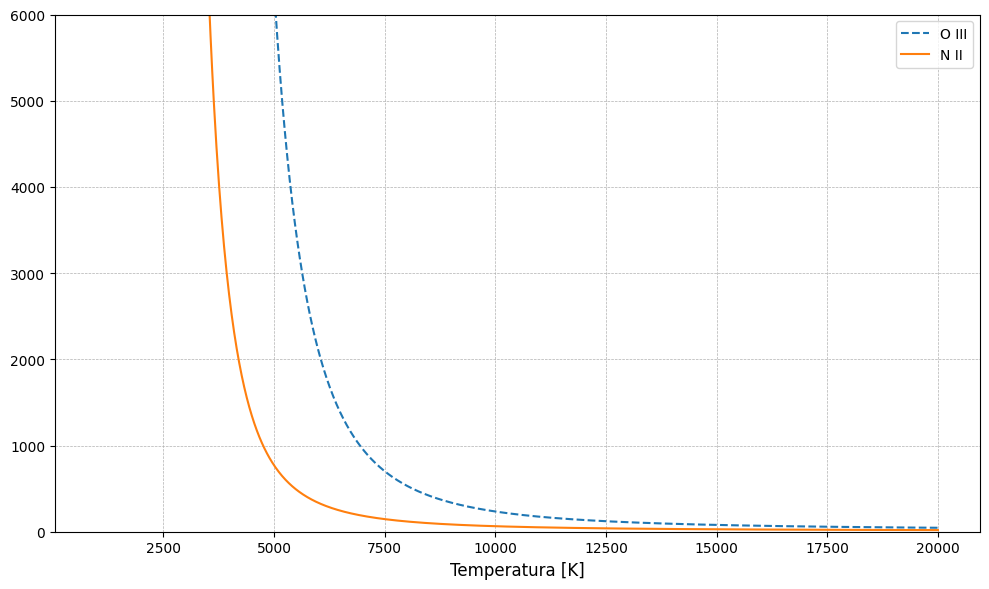

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Densidad electrónica fija
Ne = 1e-4  # por ejemplo 10^4 cm^-3

# Función para coeficiente de emisión O III
def coef_OIII(Ne, T):
    term_exp = np.exp(32985 / T)
    sqrt_T = np.sqrt(T)
    numerator = (Ne / sqrt_T) + 2.6e5 * (1 + 0.12 * np.exp(-32985 / T))
    denominator = (Ne / sqrt_T) + 1627
    return 0.054 * term_exp * (numerator / denominator)


# Función para coeficiente de emisión N II
def coef_NII(Ne, T):
    term_exp = np.exp(25007 / T)
    sqrt_T = np.sqrt(T)
    numerator = (Ne / sqrt_T) + 1.3e5 * (1 + 0.12 * np.exp(-25007 / T))
    denominator = (Ne / sqrt_T) + 250.4
    return 0.01 * term_exp * (numerator / denominator)


# Rango de temperaturas
temperatura = np.linspace(1000, 20000, 1000)
#temperatura = np.logspace(1000, 20000, 500)  # desde 1000 K hasta 20000 K

# Calcular emisividades para todo el rango de T
emisividad_OIII = coef_OIII(Ne, temperatura)
emisividad_NII = coef_NII(Ne, temperatura)

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(temperatura, emisividad_OIII, "--", label="O III")
plt.plot(temperatura, emisividad_NII, "-", label="N II")
#plt.xscale("log")
plt.ylim(0, 6000)  # Ajustar el límite del eje y

plt.xlabel("Temperatura [K]", fontsize=12)
#plt.ylabel("Coef. de emisión (unidades arbitrarias)", fontsize=12)
#plt.title(f"Coef. de emisión para $N_e = {Ne:.1e}$ cm$^{{-3}}$", fontsize=14)
plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Densidad electrónica fija
Ratio_flux = 1.2  # Relación de flujos [O II] 3726/3729

A6716 = 2.6e-4
A6731 = 8.8e-4


# Función para coeficiente de emisión O III
def Constante_Ne(Ra, A6716, A6731):
    numerator = 0.26 * ((2 / 3) * Ra * (A6716**2 / A6731) - A6731)
    denominator = 8.63e-6*(1-((2/3)*Ra*(A6716/A6731)))
    return (numerator / denominator)


Ne = 1e-4  # por ejemplo 10^4 cm^-3
# rango de Ne
Ne = np.linspace(1, 100000, 10000)
Temperature = 10000  # Temperatura en Kelvin
C = 8.63e-6 / np.sqrt(Temperature)  # Constante de densidad electrónica

ratio_SII = f6716_over_f6731(Ne, C)
ratio_OII = f3726_over_f3729(Ne, C)
# Graficar la relación de flujos
plt.figure(figsize=(10, 6))
plt.plot(Ne, ratio_SII, label="SII", color="blue")
plt.plot(Ne, ratio_OII, label="OII", color="red")
plt.title("Relación de flujos [SII] 6716/6731 y [OII] 3726/3729")
plt.xlabel("Densidad electrónica (Ne)")
plt.ylabel("Relación de flujos")
plt.xscale("log")
# plt.yscale('log')
plt.ylim(0.3, 1.6)
# plt.xlim()
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Densidad electrónica fija
Ratio_flux = 1.2  # Relación de flujos [O II] 3726/3729
Ne = 1e-4  # por ejemplo 10^4 cm^-3
A6716 = 2.6e-4
A6731 = 8.8e-4


# Función para coeficiente de emisión O III
def Constante_Ne(Ra, A6716, A6731):
    numerator = 0.26 * ((2 / 3) * Ra * (A6716**2 / A6731) - A6731)
    denominator = 8.63e-3
    return 0.054 * term_exp * (numerator / denominator)